# Preparing

## Import

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from utils import *
from joblib import Parallel, delayed
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
# matplotlib.rcdefaults()

figures saved to /tmp/figures


In [3]:
DATA_DIR = 'processed_csv/'
dfa = pd.read_csv(DATA_DIR + 'dfa.csv') # dataframe of tasks
dfas = pd.read_csv(DATA_DIR + 'dfas.csv') # tasks with sensor data but sum
dfam = pd.read_csv(DATA_DIR + 'dfas_mean.csv') # tasks with sensor data but mean
all_thr = 75

In [4]:
# dfas_w = dfas[dfas['workload'].notna()]
# dfam_w = dfam[dfam['workload'].notna()]
# dfas_w.to_csv(DATA_DIR + 'workload_dfas.csv')
# dfam_w.to_csv(DATA_DIR + 'workload_dfam.csv')

In [5]:
# figure out which job_name has appeared in multiple rows
count_series = dfa['job_name'].value_counts()
dup_task = count_series[count_series > 1].index.to_list()
names = ['tensorflow', 'worker', 'ps', 'PyTorchWorker', 'evaluator']
fail = 'Failed'
gpu_types = ['V100', 'T4', 'P100', 'V100M32']
# usr_vals = dfa.user.value_counts()
# threshold = np.percentile(usr_vals, all_thr)
# freq_user = usr_vals[usr_vals >= threshold].index.to_list()

In [6]:
# figure out high level and low level requests for cpu, gpu and memory
cpu_req_high = np.percentile(dfas['plan_cpu'], 80)
cpu_req_low = np.percentile(dfas['plan_cpu'], 15)
gpu_req_high = np.percentile(dfas['plan_gpu'], 85)
gpu_req_low = np.percentile(dfas['plan_gpu'], 13)
mem_req_high = np.percentile(dfas['plan_mem'], 86)
mem_req_low = np.percentile(dfas['plan_mem'], 8)
#TODO: need to choose from CDF, not hard threshold
runtime_high = np.percentile(dfas['runtime'][~np.isnan(dfas['runtime'])], 85)
runtime_low = np.percentile(dfas['runtime'][~np.isnan(dfas['runtime'])], 15)
wait_high = np.percentile(dfas['wait_time'][~np.isnan(dfas['wait_time'])], 85)
wait_low = np.percentile(dfas['wait_time'][~np.isnan(dfas['wait_time'])], 15)
ins_high = 2
model_dict = {'inception': 'cv', 'resnet': 'cv', 'vgg': 'cv',
             'bert': 'nlp', 'nmt': 'nlp', 'xlnet': 'nlp',
             'graphlearn': 'gnn', 'rl': 'rl', 'ctr': 'rec'}

# plot_data_cdf(dfas['user'].value_counts(), xlog=True)
#               ylabel='CDF',xlabel='Num of tasks submitted per User',
#               xticks=[1,10,100,10**3,10**4,10**5])

In [7]:
runtime_high

7829.0

In [8]:
len(dfas[dfas['runtime'] <= runtime_low]) / len(dfas)

0.10455358791952783

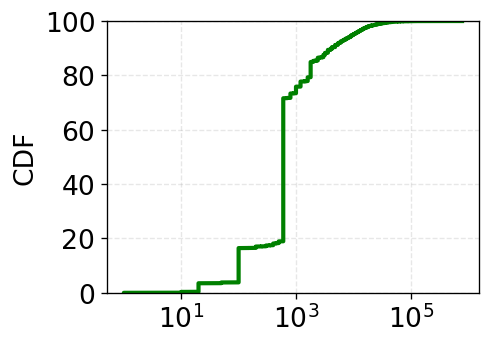

In [9]:
plot_data_cdf(dfas['plan_cpu'], xlog=True)

In [10]:
group_thr = 100
user_thr = 1000
user_counts = dfas['user'].value_counts()
new_users = user_counts[user_counts < user_thr].index.to_list()
top_user = user_counts.index[0]
group_counts = dfas['group'].value_counts()
freq_groups = group_counts[group_counts > group_thr].index.to_list()

In [19]:
dfas['gpu_type'].value_counts() / len(dfas)

MISC       0.679711
T4         0.206471
P100       0.067027
V100       0.028208
V100M32    0.018582
Name: gpu_type, dtype: float64

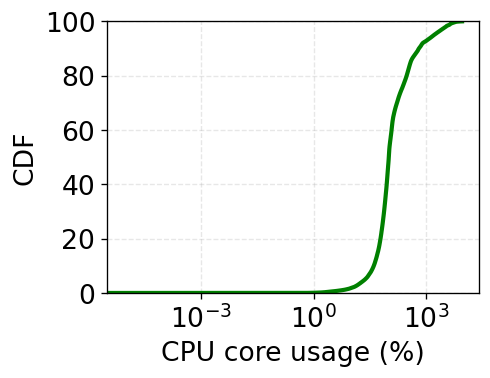

In [12]:
plot_data_cdf(dfam['cpu_usage'][~np.isnan(dfam['cpu_usage'])], xlog=True, xlabel='CPU core usage (%)')

In [13]:
csum_use_high = np.percentile(dfas['cpu_usage'][~np.isnan(dfas['cpu_usage'])], 85)
csum_use_low = np.percentile(dfas['cpu_usage'][~np.isnan(dfas['cpu_usage'])], 15)
gsum_use_high = np.percentile(dfas['gpu_wrk_util'][~np.isnan(dfas['gpu_wrk_util'])], 85)
gsum_use_low = np.percentile(dfas['gpu_wrk_util'][~np.isnan(dfas['gpu_wrk_util'])], 15) # just 0
msum_use_high = np.percentile(dfas['avg_mem'][~np.isnan(dfas['avg_mem'])], 85)
msum_use_low = np.percentile(dfas['avg_mem'][~np.isnan(dfas['avg_mem'])], 15)
gmsum_use_high = np.percentile(dfas['avg_gpu_wrk_mem'][~np.isnan(dfas['avg_gpu_wrk_mem'])], 85)
gmsum_use_low = np.percentile(dfas['avg_gpu_wrk_mem'][~np.isnan(dfas['avg_gpu_wrk_mem'])], 15) # just 0

In [14]:
# figure out usage thresholds from dfam
cavg_use_high = np.percentile(dfam['cpu_usage'][~np.isnan(dfam['cpu_usage'])], 85)
cavg_use_low = np.percentile(dfam['cpu_usage'][~np.isnan(dfam['cpu_usage'])], 15)
gavg_use_high = np.percentile(dfam['gpu_wrk_util'][~np.isnan(dfam['gpu_wrk_util'])], 85)
gavg_use_low = np.percentile(dfam['gpu_wrk_util'][~np.isnan(dfam['gpu_wrk_util'])], 15) # just 0
mavg_use_high = np.percentile(dfam['avg_mem'][~np.isnan(dfam['avg_mem'])], 85)
mavg_use_low = np.percentile(dfam['avg_mem'][~np.isnan(dfam['avg_mem'])], 15)
gmavg_use_high = np.percentile(dfam['avg_gpu_wrk_mem'][~np.isnan(dfam['avg_gpu_wrk_mem'])], 85)
gmavg_use_low = np.percentile(dfam['avg_gpu_wrk_mem'][~np.isnan(dfam['avg_gpu_wrk_mem'])], 15) # just 0

# TODO: add memory and GPU mem
# (dfam['gpu_wrk_util'][~np.isnan(dfam['gpu_wrk_util'])] / dfam['plan_gpu'][~np.isnan(dfam['gpu_wrk_util'])]).max()


In [15]:
def inner_loop(dfas, dfam):
    results = []
    for dfas_iter, dfam_iter in zip(dfas.iterrows(), dfam.iterrows()):
        trans = [] # transaction list
        dfas_row = dfas_iter[1]
        dfam_row = dfam_iter[1]
        if dfas_row['job_name'] in dup_task:
            trans.append('multi-task')
        if dfas_row['task_name'] in names:
            trans.append(dfas_row['task_name'])
        if dfas_row['status'] == fail:
            trans.append(fail)
        if dfas_row['gpu_type'] in gpu_types:
            if dfas_row['gpu_type'] == 'T4':
                trans.append('T4')
            else:
                trans.append('None-T4')
        # cpu req
        cpu_req = dfas_row['plan_cpu']
        if cpu_req >= cpu_req_high:
            trans.append('cpu_req_high')
        elif cpu_req <= cpu_req_low:
            trans.append('cpu_req_low')
        # gpu req
        gpu_req = dfas_row['plan_gpu']
        if gpu_req >= gpu_req_high:
            trans.append('gpu_req_high')
        elif gpu_req <= gpu_req_low:
            trans.append('gpu_req_low')
        # mem req
        mem_req = dfas_row['plan_mem']
        if mem_req >= mem_req_high:
            trans.append('mem_req_high')
        elif mem_req <= mem_req_low:
            trans.append('mem_req_low')    
        # runtime
        runtime = dfas_row['runtime']
        if not np.isnan(runtime):
            if runtime >= runtime_high:
                trans.append('runtime_high')
            elif runtime <= runtime_low:
                trans.append('runtime_low')   
        # wait time
        wait = dfas_row['wait_time']
        if not np.isnan(wait):
            if wait >= wait_high:
                trans.append('wait_high')
            elif wait <= wait_low:
                trans.append('wait_low')
        # multiple instance spawned
        if dfas_row['inst_num'] >= ins_high:
            trans.append('multi-inst')    
        # model type
        model = dfas_row['workload']
        if model in model_dict:
            trans.append(model_dict[model])
        # freq user and job group
        if dfas_row['group'] in freq_groups:
            trans.append('freq_group')
        if dfas_row['user'] in new_users:
            trans.append('new_user')
        elif dfas_row['user'] == top_user:
            trans.append('top_user')
        # cpu/gpu/memory usage average across instances        
        cpu_use_avg = dfam_row['cpu_usage']
        if not np.isnan(cpu_use_avg):
            if cpu_use_avg >= cavg_use_high:
                trans.append('high_cpu_avg')
            elif cpu_use_avg <= cavg_use_low:
                trans.append('low_cpu_avg')
        gpu_use_avg = dfam_row['gpu_wrk_util']
        if not np.isnan(gpu_use_avg):
            if gpu_use_avg >= gavg_use_high:
                trans.append('high_gpu_avg')
            elif gpu_use_avg <= gavg_use_low:
                trans.append('low_gpu_avg')
        mem_use_avg = dfam_row['avg_mem']
        if not np.isnan(mem_use_avg):
            if mem_use_avg >= mavg_use_high:
                trans.append('high_mem_avg')
            elif mem_use_avg <= mavg_use_low:
                trans.append('low_mem_avg')    
        gmem_use_avg = dfam_row['avg_gpu_wrk_mem']
        if not np.isnan(gmem_use_avg):
            if gmem_use_avg >= gmavg_use_high:
                trans.append('high_gmem_avg')
            elif gmem_use_avg <= gmavg_use_low:
                trans.append('low_gmem_avg')      
        results.append(trans)
    return results

In [16]:
dfas_chunk = pd.read_csv(DATA_DIR + 'workload_dfas.csv', chunksize=5000) # tasks with sensor data but sum
dfam_chunk = pd.read_csv(DATA_DIR + 'workload_dfam.csv', chunksize=5000) # tasks with sensor data but mean

In [17]:
usable_cores = os.sched_getaffinity(0)
dataset = Parallel(n_jobs=len(usable_cores))(delayed(inner_loop)(dfas, dfam) for dfas, dfam in zip(dfas_chunk, dfam_chunk))



In [17]:
transactions = []
for data in dataset:
    transactions += data

In [18]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)


In [1]:
df

NameError: name 'df' is not defined

In [36]:
df['cv'].sum() / len(df)

0.05941939072394318

In [24]:
frequent_itemsets = fpgrowth(df, min_support=0.2, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.507520,(worker)
1,0.428108,(multi-inst)
2,0.422685,(cpu_req_high)
3,0.401035,(multi-task)
4,0.354313,(gpu_req_high)
...,...,...
62,0.220477,"(rec, wait_low, multi-task)"
63,0.220435,"(rec, T4, wait_low, multi-task)"
64,0.290080,"(rec, T4, multi-task)"
65,0.213503,"(tensorflow, text)"


In [25]:
from mlxtend.frequent_patterns import association_rules

res = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)

In [26]:
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(multi-inst),(worker),0.428108,0.507520,0.417155,0.974415,1.919955,0.199882,19.248574
1,(worker),(multi-inst),0.507520,0.428108,0.417155,0.821949,1.919955,0.199882,3.211948
2,"(multi-inst, T4)",(worker),0.285973,0.507520,0.285438,0.998130,1.966682,0.140301,263.329226
3,"(cpu_req_high, multi-inst)",(worker),0.295589,0.507520,0.285010,0.964211,1.899849,0.134993,13.760567
4,"(cpu_req_high, worker)",(multi-inst),0.327197,0.428108,0.285010,0.871065,2.034683,0.144934,4.435495
...,...,...,...,...,...,...,...,...,...
64,"(rec, multi-task)",(T4),0.291749,0.508621,0.290080,0.994280,1.954854,0.141690,85.912504
65,"(T4, multi-task)",(rec),0.294102,0.331187,0.290080,0.986325,2.978152,0.192677,48.906959
66,(rec),"(T4, multi-task)",0.331187,0.294102,0.290080,0.875880,2.978152,0.192677,5.687228
67,(tensorflow),(text),0.255744,0.577358,0.213503,0.834832,1.445953,0.065848,2.558865


In [27]:
res.to_csv('workload_rule.csv')

In [22]:
dfas

,Unnamed: 0,job_name,task_name,inst_num,status,start_time,end_time,gpu_type,inst_id,user,status_j,start_time_j,end_time_j,runtime,status_i,start_time_i,end_time_i,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload,cpu_usage,gpu_wrk_util,avg_mem,avg_gpu_wrk_mem,plan_cpu,plan_gpu,plan_mem,cap_cpu,cap_gpu,cap_mem
0,0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,MISC,990f1799a5093b62142b101c0227875b81c7f0329301df98af1148ec8724,58540f191766,Terminated,2693235.0,2695847.0,2612.0,Terminated,2693240.0,2695847.0,2607.0,43.450000,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN,350.353167,77.468451,24.306558,4.184025,600.0,50.0,29.296875,96,8,512
1,1,455c3dec270f4777ad67721c,tensorflow,1.0,Terminated,3399583.0,3399732.0,MISC,d94b4b01a6dd6c1865972cd628abe206422143ef37e6d449d4b2e862e574,ebba56ec23b9,Terminated,3399583.0,3399732.0,149.0,Terminated,3399681.0,3399732.0,51.0,0.850000,98.0,1970-02-09 16:19:43+08:00,NaN,5a3163d07db392e47b6f0d063906592f,NaN,117.888889,0.333333,1.870295,0.069743,600.0,100.0,29.296875,96,8,512
2,2,ba64aa2f0feff18428923e92,tensorflow,1.0,Terminated,2152271.0,2158213.0,MISC,af71dfe31db0378561e1bea2c26605f67cb7611f0d38661b43881a1c6006,de69ddc1064e,Terminated,2152271.0,2158213.0,5942.0,Terminated,2152280.0,2158213.0,5933.0,98.883333,9.0,1970-01-26 05:51:11+08:00,NaN,f94dcf2c0efdf3fd36f75dbe1709c43f,NaN,139.502103,4.408403,12.811959,4.212840,600.0,50.0,29.296875,96,8,512
3,3,704783be2a4b7f88b8d2e4ee,worker,100.0,Failed,2172980.0,NaN,MISC,a63da076c1210109040acf759e2c1d00b8abc2d84305990a5941d0142690,cfcb2e0deb93,Failed,2172974.0,2173216.0,NaN,Interrupted,2172995.0,NaN,NaN,NaN,15.0,1970-01-26 11:36:20+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN,4152.975415,582.481221,821.026606,20.235918,27600.0,460.0,449.218750,4416,368,23552
4,4,bce3b9c55772f9d1e85fe796,PyTorchWorker,4.0,Failed,2374681.0,NaN,V100,8dd676ab7fef90186d5813c5255ce4e89b50bdd9854225e7fa082289c88f,11b3ab54fc9f,Failed,2374681.0,NaN,NaN,Interrupted,2374699.0,2378674.0,NaN,NaN,18.0,1970-01-28 19:38:01+08:00,V100,a2e43ea2be689ce60787b3174f3ffbbf,NaN,0.000000,0.000000,0.009766,0.000000,800.0,200.0,20.000000,192,16,1024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
850028,850028,31271edf22fc09d66691b610,tensorflow,1.0,Terminated,4725236.0,4727490.0,MISC,c784fb15b3236a8dc792b0eab24f5f473b03d25d76dc1ed83fd62c6159c3,58540f191766,Terminated,4725236.0,4727490.0,2254.0,Terminated,4725241.0,4727490.0,2249.0,37.483333,5.0,1970-02-25 00:33:56+08:00,NaN,71ac858c1c3eda444dbc203327feaf75,NaN,63.042222,0.000000,3.048873,0.198406,100.0,25.0,29.296875,96,8,512
850029,850029,f79493b18df6dabdaa578dac,tensorflow,1.0,Failed,4788805.0,NaN,P100,5dce09bd3b48900c4907976028dde42fd1e15b08e27d4264b75bb4751ff3,58540f191766,Failed,4788805.0,NaN,NaN,Failed,4788815.0,NaN,NaN,NaN,10.0,1970-02-25 18:13:25+08:00,NaN,06e75b73e83f0249a9f672f7a1295502,NaN,93.666667,0.187500,2.704799,0.157288,600.0,100.0,29.296875,64,2,512
850030,850030,d14050801987e35369e03724,tensorflow,1.0,Failed,4800428.0,NaN,P100,61a9ba84b9d32db3a970e3eee322633e039fdb429d89ce92894ef2122ad1,58540f191766,Failed,4800428.0,NaN,NaN,Failed,4800441.0,NaN,NaN,NaN,13.0,1970-02-25 21:27:08+08:00,NaN,b664d3856c1e2af43229ecc35c6d2569,NaN,73.461538,2.625000,1.946219,0.365112,600.0,100.0,29.296875,64,2,512
850031,850031,906db91bc6f3321e94a6b472,tensorflow,1.0,Terminated,4732036.0,4739163.0,MISC,07396d56aac1ecf5d65f22b5f53f2a72327dce42195872b0eb8ee973f6b6,58540f191766,Terminated,4732036.0,4739163.0,7127.0,Terminated,4733523.0,4739163.0,5640.0,94.000000,1487.0,1970-02-25 02:27:16+08:00,NaN,a39aa3320b3ed75a35d0297f73f05283,NaN,1637.419698,0.000000,15.379433,0.133434,600.0,10.0,29.296875,96,8,512


In [23]:
    # cpu/gpu/memory usage sum
#     cpu_use_sum = dfas['cpu_usage'][ind]
#     if not np.isnan(cpu_use_sum):
#         if cpu_use_sum >= csum_use_high:
#             trans.append('high_cpu_sum')
#         elif cpu_use_sum <= csum_use_low:
#             trans.append('low_cpu_sum')
#     gpu_use_sum = dfas['gpu_wrk_util'][ind]
#     if not np.isnan(gpu_use_sum):
#         if gpu_use_sum >= gsum_use_high:
#             trans.append('high_gpu_sum')
#         elif gpu_use_sum <= gsum_use_low:
#             trans.append('low_gpu_sum')
#     mem_use_sum = dfas['avg_mem'][ind]
#     if not np.isnan(mem_use_sum):
#         if mem_use_sum >= msum_use_high:
#             trans.append('high_mem_sum')
#         elif mem_use_sum <= msum_use_low:
#             trans.append('low_mem_sum')    
#     gmem_use_sum = dfas['avg_gpu_wrk_mem'][ind]
#     if not np.isnan(gmem_use_sum):
#         if gmem_use_sum >= gmsum_use_high:
#             trans.append('high_gmem_sum')
#         elif gmem_use_sum <= gmsum_use_low:
#             trans.append('low_gmem_sum')        